<a href="https://www.nvidia.com/dli"> <img src="../images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# Authorship Attribution

Authorship attribution is a type of text classification problem.  Instead of categorizing text by _topic_, as you did in the disease text classification problem, the objective is to classify the text by _author_.  

The inherent assumption in trying to solve a problem like this is that there is *some difference between the styles* of the authors in question, *which can be discerned by a model*.  Is that the case for BERT et al?  Is a language model able to "understand" written style? 

### Table of Contents
[The Problem](#The-Problem)<br>
[Scoring](#Scoring)<br>
[Step 1: Prepare the Data](#Step-1:-Prepare-the-Data)<br>
[Step 2: Prepare the Training Pipeline](#Step-2:-Prepare-the-Training-Pipeline)<br>
[Step 3: Prepare the Validation Pipeline](#Step-3:-Prepare-the-Validation-Pipeline)<br>
[Step 4: Train](#Step-4:-Train)<br>
[Step 5: Infer](#Step-5:-Infer)<br>
[Step 6: Submit You Assessment](#Step-6:-Submit-You-Assessment)

# The Problem
### The Federalist Papers - History Mystery!

The [Federalist Papers](https://en.wikipedia.org/wiki/The_Federalist_Papers) are a set of essays written between 1787 and 1788 by [Alexander Hamilton](https://en.wikipedia.org/wiki/Alexander_Hamilton), [James Madison](https://en.wikipedia.org/wiki/James_Madison) and [John Jay](https://en.wikipedia.org/wiki/John_Jay).  Initially published under the pseudonym 'Publius', their intent was to encourage the ratification of the then-new Constitution of the United States of America.  In later years, a list emerged where the author of each one of the 85 papers was identified.  Nevertheless, for a subset of these papers the author is still in question.  The problem of the Federalist Papers authorship attribution has been a subject of much research in statistical NLP in the past.   Now you will try to solve this question with your own BERT-based project model.
<img style="float: right;" src="images/HandM.png" width=400>
                                                                                                           
In concrete terms, the problem is identifying, for each one of the disputed papers, whether Alexander Hamilton or James Madison are the authors.  For this exercise, you can assume that each paper has a single author, i.e., that no collaboration took place (though *that* is not 100% certain!), and that each author has a well-defined writing style that is displayed across all the identified papers. 

### Your Project
You are provided with labeled `train.tsv` and `dev.tsv` datasets for the project.  There are 10 test sets, one for each of the disputed papers.  All datasets are contained in the `data/federalist_papers_HM` directory.  

Each "sentence" is actually a group of sentences of approximately 256 words.  The labels are '0' for HAMILTON and '1' for MADISON.  There are more papers by Hamilton in the example files than by Madison.  The validation set has been created with approximately the same distribution of the two labels as in the training set.

Your task is to build neural networks using NeMo, as you did in Lab 2.  You'll train your model and test it.  Then you'll use provided collation code to see what answers your model gives to the "history mystery"! 

Along the way, you'll save code snippets that will be tested with the autograder one you are done.  You'll follow submission instructions at the end of the notebook for this part.

# Scoring
You will be assessed on your ability to set up and train a model for the project, rather than the final result.  This coding assessment is worth 70 points, divided as follows:

### Rubric

| Step                               | Graded                         | FIXMEs?  | Points |
|------------------------------------|--------------------------------|----------|--------|
| 1. Prepare the Project             | Set project parameters (parameters are in range)        |  4       | 12     |
| 2. Prepare the Training Pipeline   | Create training neural modules (modules are correct) |  4       | 20     |
| 3. Prepare the Validation Pipeline | Create the validation graph (connections are correct)   |  4       | 20     |
| 4. Train                           | Run the Trainer (training logs indicate training correct)               |  1       | 8     |
| 5. Infer                           | Run Inference (results indicate working project)                |  0       | 10     |

Although you are very capable at this point of building the project without any help at all, some scaffolding is provided, including specific names for variables.  This is for the benefit of the autograder, so please use these constructs for your assessment.  You are free to change parameters such as model name, sequence length, batch size, learning rate, number of epochs, and so on to improve your model as you see fit. 

Once you are confident that you've built a reliable model, follow the instructions for submission at the end of the notebook.

### Resources and Hints
* **Example code:**<br>
In the file browser at your left, you'll find the `lab2_reference_notebooks` directory.  This contains solution notebooks from Lab 2 for text classification and NER to use as examples.
* **Language model (PRETRAINED_MODEL_NAME):**<br>
You may find it useful to try different language models to better discern style.  Specifically, it may be that capitalization is important, which would mean you'd want to try a "cased" model.
* **Maximum sequence length (MAX_SEQ_LEN):**<br>
Values that can be used for MAX_SEQ_LENGTH are 64, 128, or 256.  Larger models (BERT-large, Megatron) may require a smaller MAX_SEQ_LENGTH to avoid an out-of-memory error.
* **Number of Classes (NUM_CLASSES):**<br>
For the Federalist Papers, we are only concerned with HAMILTON and MADISON.  The papers by John Jay have been excluded from the dataset.
* **Batch size (BATCH_SIZE):**<br>
Larger batch sizes train faster, but large language models tend to use up the available memory quickly.
* **Memory usage:**<br>
Some of the models are very large.   If you get "RuntimeError: CUDA out of memory" during training, you'll know you need to reduce the batch size, sequence length, and/or choose a smaller language model, restart the kernel, and try again from the beginning of the notebook.
* **Accuracy and loss:**<br>
It is definitely possible to achieve 95% or more model accuracy for this project.  In addition to changes in accuracy as the model trains, pay attention to the loss value.  You want the loss value to be dropping and getting very small for best results.
* **Number of epochs (NUM_EPOCHS):**<br>
You may need to run more epochs for your model (or not!).  Since checkpoints are saved, you can  increase the number of epochs and run that cell plus the remaining the cells again.  Note that there may be memory limitations when running 20 or more new epochs at one time.

# Step 1: Prepare the Data

### Python Imports
This block is complete, but feel free to add to it (not graded).

In [1]:
# Import useful math and utility libraries
import os
import json
import math
import json
import pickle
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = -1
import torch

# Import the nemo toolkit and NLP libraries
import nemo
import nemo.collections.nlp as nemo_nlp

# Import the specific neural modules we need
from nemo.collections.nlp.nm.data_layers import BertTextClassificationDataLayer
from nemo.collections.nlp.nm.trainables import get_pretrained_lm_model, SequenceClassifier
from nemo.backends.pytorch.common.losses import CrossEntropyLossNM
    
# Import helpers for fetching the learning rate and tokenizer functions
from nemo.utils.lr_policies import get_lr_policy
from nemo.collections.nlp.data.tokenizers import get_tokenizer

# Import callbacks and callback functions
from nemo.core import SimpleLogger, TensorboardLogger, EvaluatorCallback, CheckpointCallback
from nemo.collections.nlp.callbacks.text_classification_callback import eval_iter_callback, eval_epochs_done_callback

# Identify the input data location.
DATA_DIR = '/dli/task/data/federalist_papers_HM/'

[NeMo W 2021-06-09 13:37:38 audio_preprocessing:56] Could not import torchaudio. Some features might not work.


### Input Parameters (not graded)
Choose your model and log location.  A few are provided to choose from.  Just uncomment one pair of `PRETRAINED_MODEL_NAME` and `WORK_DIR` assignments.

In [2]:
# Identify the pretrained model 
# and where information and checkpoints will be logged

PRETRAINED_MODEL_NAME = 'bert-base-uncased'
WORK_DIR = '/dli/task/data/logs-bbu/'

# PRETRAINED_MODEL_NAME = 'bert-base-cased'
# WORK_DIR = '/dli/task/data/logs-bbc/'

# PRETRAINED_MODEL_NAME = 'megatron-bert-345m-uncased'
# WORK_DIR = '/dli/task/data/logs-m345u/'

# PRETRAINED_MODEL_NAME = 'bert-large-uncased'
# WORK_DIR = '/dli/task/data/logs-blu/'

### Set sizing parameters (graded)
Complete the <i><strong style="color:green;">#FIXME</strong></i> lines and run the save cell.

In [3]:
# Set the number of words in the sequences
# Set the number of classes for the classifier
# Set the batch size for processing
MAX_SEQ_LEN = 128 #FIXME 
NUM_CLASSES = 2 #FIXME
BATCH_SIZE = 64 #FIXME
# To use mixed precision, set AMP_OPTIMIZATION_LEVEL to 'O1' or 'O2',
# to train without mixed precision, set it to 'O0'.
AMP_OPTIMIZATION_LEVEL = 'O1'

# Step 2: Prepare the Training Pipeline

<img src="../images/nemo/nm-pipe.png" width=800>

### NeuralModuleFactory (not graded)

In [5]:
# Instantiate the neural module factory
nf = nemo.core.NeuralModuleFactory(log_dir=WORK_DIR,
                                   create_tb_writer=True,
                                   add_time_to_log_dir=False,
                                   optimization_level=AMP_OPTIMIZATION_LEVEL)

### Create the Training Neural Modules (graded)
Complete the <i><strong style="color:green;">#FIXME</strong></i> lines in the following cells to create four neural modules. Each cell includes a sanity check for your convenience.  Finally, run the save cell as well.

In [6]:
# Instantiate the data Layer neural module for training.
#     Include the input file locations, tokenizer, max_seq_length, and batch size.
#     Set the shuffle and use_cache to True for training  
USE_CACHE = True
tokenizer = get_tokenizer(tokenizer_name='nemobert', pretrained_model_name=PRETRAINED_MODEL_NAME)
dl_train = BertTextClassificationDataLayer(input_file=os.path.join(DATA_DIR, 'train.tsv'),
                                             tokenizer=tokenizer,
                                             max_seq_length=MAX_SEQ_LEN,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             use_cache=USE_CACHE) #FIXME

# Sanity check
print('dl_train features include batchsize of {} and shuffle = {}'.format(dl_train._batch_size, dl_train._shuffle))

[NeMo I 2021-06-09 13:42:15 bert_tokenizer:78] Deriving bert model type from pretrained model name.



[NeMo I 2021-06-09 13:42:16 text_classification_dataset:82] /dli/task/data/federalist_papers_HM/train.tsv: 502
[NeMo I 2021-06-09 13:42:26 data_preprocessing:250] Min: 257 |                  Max: 474 |                  Mean: 295.1792828685259 |                  Median: 288.0
[NeMo I 2021-06-09 13:42:26 data_preprocessing:252] 75 percentile: 306.75
[NeMo I 2021-06-09 13:42:26 data_preprocessing:253] 99 percentile: 387.0
[NeMo I 2021-06-09 13:42:26 text_classification_dataset:118] 502 out of 502                         sentences with more than 128 subtokens.
[NeMo I 2021-06-09 13:42:26 text_classification_dataset:175] *** Example ***
[NeMo I 2021-06-09 13:42:26 text_classification_dataset:176] example_index: 0
[NeMo I 2021-06-09 13:42:26 text_classification_dataset:177] subtokens: [CLS] principle of the innovation ? do these principles , in fine , require that the powers of the general government should be limited , and that , beyond this limit , the states should be left in possession 

In [7]:
# Instantiate the Language Model with the get_pretrained_lm_model function
#    Include the pretrained_model_name as the parameter
lm =  get_pretrained_lm_model(pretrained_model_name=PRETRAINED_MODEL_NAME) #FIXME

# Sanity check the number of weight parameters
print(f'{PRETRAINED_MODEL_NAME} has {lm.num_weights} weights')


bert-base-uncased has 109482240 weights


In [8]:
# Instantiate the SequenceClassifier
#    Include the hidden_size, num_classes (which is NUM_CLASSES), num_layers (set to 2), 
#    and a dropout rate of 0.1
lm_hidden_size = lm.hidden_size
classifier = SequenceClassifier(hidden_size=lm.hidden_size, 
                         num_classes=3, 
                         num_layers=2, 
                         dropout=0.1) #FIXME

# Sanity check the number of weight parameters
print(f'Classifier has {classifier.num_weights} weights')

Classifier has 592899 weights


In [9]:
# Instantiate the CrossEntropyLossNM Loss Function (no parameters required)
loss = CrossEntropyLossNM() #FIXME

# Sanity check the loss - it should be ModuleType "loss"
print(loss._type)

ModuleType.loss


### Create the Training Graph (not graded)

In [11]:
# Define the data output from the data layer
train_data = dl_train()

# Define train_embeddings from the language model, based on inputs from the data layer  
train_embeddings = lm(input_ids=train_data.input_ids,
                      token_type_ids=train_data.input_type_ids,
                      attention_mask=train_data.input_mask)

# Define the train_logits from the clasifier, based on the embeddings from the language model
train_logits = classifier(hidden_states=train_embeddings)

# Define the train_loss based on the classifier logits and data layer labels
train_loss = loss(logits=train_logits, labels=train_data.labels)

# Sanity check the outputs
print('Types are:\n{}\n{}\n{}\n{}'.format(train_data, train_embeddings, train_logits, train_loss))

Types are:
BertTextClassificationDataLayerOutput(input_ids=<nemo.core.neural_types.neural_type.NmTensor object at 0x7fdece8e22e8>, input_type_ids=<nemo.core.neural_types.neural_type.NmTensor object at 0x7fdece8e2390>, input_mask=<nemo.core.neural_types.neural_type.NmTensor object at 0x7fdece8e23c8>, labels=<nemo.core.neural_types.neural_type.NmTensor object at 0x7fdece8e24a8>)
hidden_states
logits
loss


# Step 3: Prepare the Validation Pipeline

### Create the Validataion Data Layer Neural Module (not graded)

In [12]:
# Instantiate the data Layer neural module for validation. 
dl_val = BertTextClassificationDataLayer(input_file=os.path.join(DATA_DIR, 'dev.tsv'),
                                             tokenizer=tokenizer,
                                             max_seq_length=MAX_SEQ_LEN,
                                             batch_size=BATCH_SIZE,
                                             use_cache=USE_CACHE)

# Sanity check
print('dl_val features include batchsize of {} and shuffle = {}'.format(dl_val._batch_size, dl_val._shuffle))

[NeMo I 2021-06-09 13:44:22 text_classification_dataset:82] /dli/task/data/federalist_papers_HM/dev.tsv: 115
[NeMo I 2021-06-09 13:44:24 data_preprocessing:250] Min: 257 |                  Max: 384 |                  Mean: 298.17391304347825 |                  Median: 294.0
[NeMo I 2021-06-09 13:44:24 data_preprocessing:252] 75 percentile: 316.5
[NeMo I 2021-06-09 13:44:24 data_preprocessing:253] 99 percentile: 374.18
[NeMo I 2021-06-09 13:44:24 text_classification_dataset:118] 115 out of 115                         sentences with more than 128 subtokens.
[NeMo I 2021-06-09 13:44:24 text_classification_dataset:175] *** Example ***
[NeMo I 2021-06-09 13:44:24 text_classification_dataset:176] example_index: 0
[NeMo I 2021-06-09 13:44:24 text_classification_dataset:177] subtokens: [CLS] ##pp ##lan ##ted , either in particular branches of traffic or in the general advantages of trade and navigation . from this summary of what has taken place in other countries , whose situations have borne

### Create the Validation Graph (graded)
Complete the <i><strong style="color:green;">#FIXME</strong></i> lines in the following cell.  Then, run the cell that saves the data.

In [15]:
# Define the data output from the data layer
val_data = dl_train() #FIXME

# Define val_embeddings from the language model, based on inputs from the data layer  
val_embeddings = lm(input_ids=train_data.input_ids,
                      token_type_ids=train_data.input_type_ids,
                      attention_mask=train_data.input_mask) #FIXME

# Define val_logits from the clasifier, based on the embeddings from the language model
val_logits = classifier(hidden_states=val_embeddings) #FIXME

# Define val_loss based on the classifier logits and data layer labels
val_loss = loss(logits=train_logits, labels=train_data.labels) #FIXME

# Sanity check the types - they should be the same as for the training graph (not None!)
print('Types are:\n{}\n{}\n{}\n{}'.format(val_data, val_embeddings, val_logits, val_loss))

Types are:
BertTextClassificationDataLayerOutput(input_ids=<nemo.core.neural_types.neural_type.NmTensor object at 0x7fdf7fb8f9b0>, input_type_ids=<nemo.core.neural_types.neural_type.NmTensor object at 0x7fdf7fb8fe10>, input_mask=<nemo.core.neural_types.neural_type.NmTensor object at 0x7fdece91f080>, labels=<nemo.core.neural_types.neural_type.NmTensor object at 0x7fdece91f160>)
hidden_states
logits
loss


# Step 4: Train

### Calculate steps (not graded)

In [17]:
NUM_EPOCHS = 15
NUM_GPUS = 1  # always should be 1 for these labs

train_data_size = len(dl_train)
steps_per_epoch = math.ceil(train_data_size / (BATCH_SIZE * NUM_GPUS))

### Set optimizer and learning rate (not graded)

In [18]:
OPTIMIZER = 'adam'
LEARNING_RATE = 1e-4
WARMUP_RATIO = 0.1

lr_policy_fn = get_lr_policy("WarmupAnnealing", 
                             total_steps=NUM_EPOCHS * steps_per_epoch, 
                             warmup_ratio=WARMUP_RATIO
)

### Create the Callbacks (not graded)

In [19]:
# Create callback for simple logging
train_callback = SimpleLogger(step_freq=steps_per_epoch)

# Create callback for tensorboard logging
tensorboard_callback = TensorboardLogger(nf.tb_writer,
                                        step_freq=steps_per_epoch)

# Create callback to evaluate each epoch against the validation data
eval_callback = EvaluatorCallback(eval_tensors=[val_logits, val_data.labels],
                                            user_iter_callback=lambda x, y: eval_iter_callback(x, y, dl_val),
                                            user_epochs_done_callback=lambda x:
                                                eval_epochs_done_callback(x, f'{nf.work_dir}graphs'),
                                            tb_writer=nf.tb_writer,
                                            eval_step=steps_per_epoch)

# Create callback to save checkpoints
ckpt_callback = CheckpointCallback(folder=nf.checkpoint_dir,
                                             epoch_freq=1)

### Run the Trainer (graded)
Complete the <i><strong style="color:green;">#FIXME</strong></i> in the following cell.  Then, run the cell that saves the data.

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
[NeMo I 2021-06-09 13:48:12 callbacks:534] Found 2 modules with weights:
[NeMo I 2021-06-09 13:48:12 callbacks:536] BERT
[NeMo I 2021-06-09 13:48:12 callbacks:536] SequenceClassifier
[NeMo I 2021-06-09 13:48:12 callbacks:537] Total model parameters: 110075139
[NeMo I 2021-06-09 13:48:12 callbacks:473] Found chec

[NeMo W 2021-06-09 13:48:12 callbacks:499] For module BERT, no file matches  in /dli/task/data/logs-bbu/checkpoints
[NeMo W 2021-06-09 13:48:12 callbacks:501] Checkpoint folder /dli/task/data/logs-bbu/checkpoints was present but nothing was restored. Continuing training from random initialization.


[NeMo I 2021-06-09 13:48:13 callbacks:232] loss: 0.979531
[NeMo I 2021-06-09 13:48:13 deprecated_callbacks:316] Doing Evaluation ..............................
[NeMo I 2021-06-09 13:48:14 text_classification_callback:57] Accuracy: 0.7290836653386454
[NeMo I 2021-06-09 13:48:14 text_classification_callback:64] Sampled preds: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[NeMo I 2021-06-09 13:48:14 text_classification_callback:65] Sampled labels: [0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0]
[NeMo I 2021-06-09 13:48:14 callback_utils:92] Confusion matrix:
    [[366   0]
     [136   0]]
[NeMo I 2021-06-09 13:48:14 text_classification_callback:67]               precision    recall  f1-score   support
    
               0     0.7291    1.0000    0.8433       366
               1     0.0000    0.0000    0.0000       136
    
        accuracy                         0.7291       502
       macro avg     0.3645    0.5000    0.4217       502
    weighted avg     0.5316    0.7291    0.6148       502
  

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[NeMo I 2021-06-09 13:48:16 callbacks:232] loss: 0.6168225
[NeMo I 2021-06-09 13:48:16 deprecated_callbacks:316] Doing Evaluation ..............................
[NeMo I 2021-06-09 13:48:17 text_classification_callback:57] Accuracy: 0.7290836653386454
[NeMo I 2021-06-09 13:48:17 text_classification_callback:64] Sampled preds: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[NeMo I 2021-06-09 13:48:17 text_classification_callback:65] Sampled labels: [0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0]
[NeMo I 2021-06-09 13:48:17 callback_utils:92] Confusion matrix:
    [[366   0]
     [136   0]]
[NeMo I 2021-06-09 13:48:17 text_classification_callback:67]               precision    recall  f1-score   support
    
               0     0.7291    1.0000    0.8433       366
               1     0.0000    0.0000    0.0000       136
    
        accuracy                         0.7291       502
       macro avg     0.3645    0.5000    0.4217       502
    weighted avg     0.5316    0.7291    0.6148       502
 

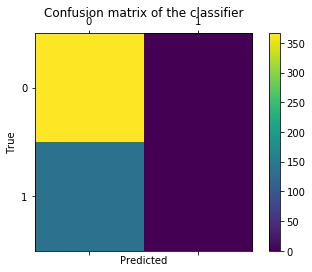

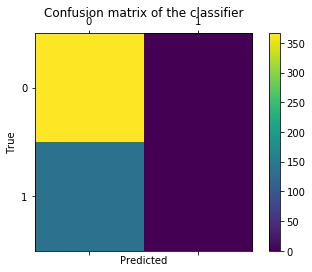

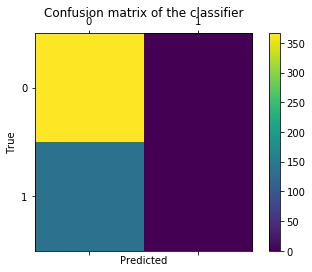

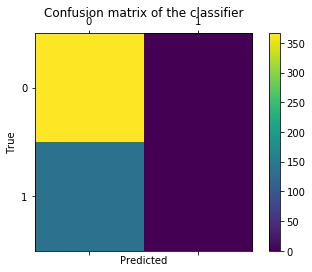

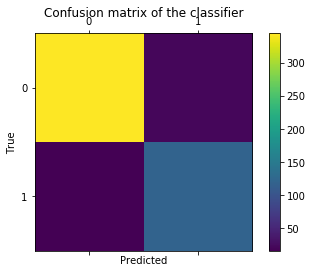

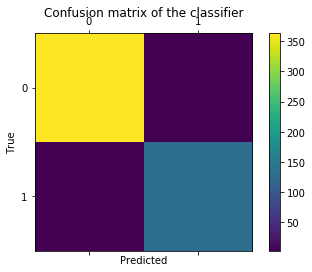

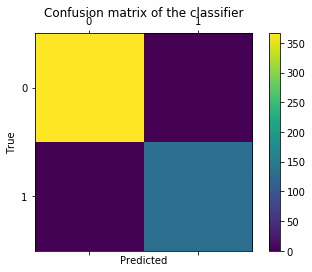

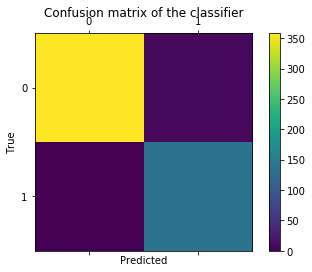

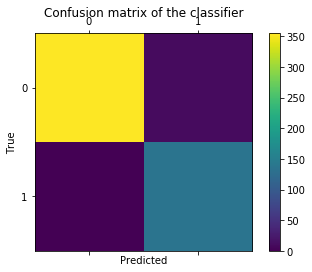

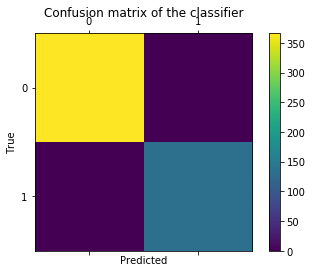

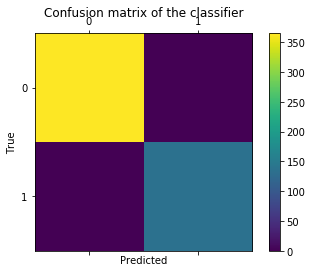

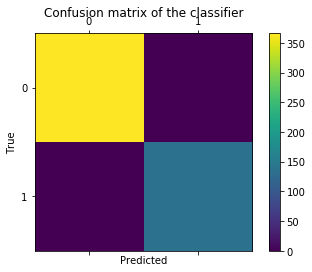

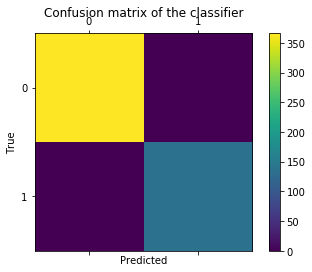

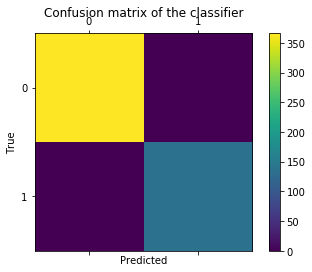

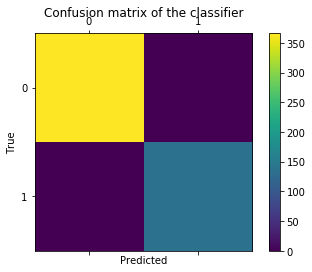

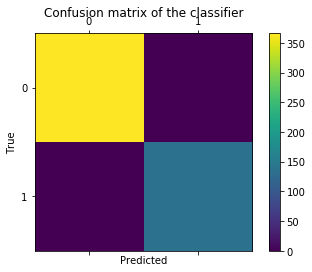

In [20]:
%%time
nemo.core.NeuralModuleFactory.reset_trainer(nf)
#FIXME Complete the nf.train parameters
nf.train(tensors_to_optimize=[train_loss],
         callbacks=[train_callback, tensorboard_callback, eval_callback, ckpt_callback],
         lr_policy=lr_policy_fn,
         optimizer=OPTIMIZER,
         optimization_params={'num_epochs': NUM_EPOCHS, 'lr': LEARNING_RATE})

# Step 5: Infer

### Prepare the Test Data for Each Paper (not graded)

In [22]:
def add_label_to_test_data(input_file, output_file):
    """ Add a nominal 'label' column to each test file and save it """
    df = pd.read_csv(input_file, sep='\t')
    # verify not done already
    if 'label' not in df:
        df['label'] = 0
        df = df[['sentence', 'label']]
    df.to_csv(output_file, sep='\t', index=False)
    
def sample_classification(sample):
    """ Extract the tensor probabilities from inference """
    sentence = sample.sentence
    prob0 = sample.prob0.values[0]
    prob1 = sample.prob1.values[0]
    result = f'{sentence} \n HAMILTON | MADISON \n {prob0} | {prob1}'
    return result

# Add the label column to all the test sets by disputed paper
test_files = [
    'test49.tsv',
    'test50.tsv',
    'test51.tsv',
    'test52.tsv',
    'test53.tsv',
    'test54.tsv', 
    'test55.tsv',
    'test56.tsv',
    'test57.tsv',
    'test62.tsv',
]

for test_file in test_files:
    add_label_to_test_data(DATA_DIR + test_file, DATA_DIR + 'labeled_' + test_file)

### Create Test Inference Runner (not graded)

In [23]:
def classify_paper(nf, tokenizer, bert, mlp, test_file, save_file):
    """ Run inference on a test_file and save the probabilities found """
    
    # Create the data layer neural module and test graph
    dl_tmp = BertTextClassificationDataLayer(input_file=test_file,
                                               tokenizer=tokenizer,
                                               max_seq_length=MAX_SEQ_LEN,
                                               batch_size=1)
    
    tmp_data = dl_tmp()
    tmp_embeddings = bert(input_ids=tmp_data.input_ids,
                          token_type_ids=tmp_data.input_type_ids,
                          attention_mask=tmp_data.input_mask)
    tmp_logits = mlp(hidden_states=tmp_embeddings)
    
    # Run inference
    tmp_logits_tensors = nf.infer(tensors=[tmp_logits, tmp_embeddings])
    
    # Convert the tensor likelilhoods to probabilities and save
    tmp_probs = [torch.nn.functional.softmax(torch.cat(tmp_logits_tensors[0]), dim=1).numpy()[:, label_index] for label_index in range(NUM_CLASSES)]
    tmp_df = pd.read_csv(test_file, sep='\t')
    tmp_df['prob0'] = tmp_probs[0] 
    tmp_df['prob1'] = tmp_probs[1]
    tmp_df.to_csv(save_file, sep='\t', index=False)
    
    # Prepare an information output string
    avg = round(float(tmp_df['prob0'].mean()),3)
    std = round(float(tmp_df['prob0'].std()),3)
    name = 'HAMILTON' if avg > 0.5 else 'MADISON'
    result_string = '{} {} mean: {} std: {}\n'.format(name, test_file, avg, std)
    return result_string

### Run Inference (graded)
Run the inference blocks to see and save the results.

In [24]:
print_collated_output = ''
for test_file in test_files:
    result = classify_paper(nf, tokenizer, lm, classifier, DATA_DIR + 'labeled_' + test_file, DATA_DIR + 'inference_result_' + test_file)
    print_collated_output += result

[NeMo I 2021-06-09 13:53:24 text_classification_dataset:82] /dli/task/data/federalist_papers_HM/labeled_test49.tsv: 7
[NeMo I 2021-06-09 13:53:24 data_preprocessing:250] Min: 258 |                  Max: 322 |                  Mean: 287.42857142857144 |                  Median: 283.0
[NeMo I 2021-06-09 13:53:24 data_preprocessing:252] 75 percentile: 295.5
[NeMo I 2021-06-09 13:53:24 data_preprocessing:253] 99 percentile: 320.8
[NeMo I 2021-06-09 13:53:24 text_classification_dataset:118] 7 out of 7                         sentences with more than 128 subtokens.
[NeMo I 2021-06-09 13:53:24 text_classification_dataset:175] *** Example ***
[NeMo I 2021-06-09 13:53:24 text_classification_dataset:176] example_index: 0
[NeMo I 2021-06-09 13:53:24 text_classification_dataset:177] subtokens: [CLS] ought to be guarded . one of the precautions which he proposes , and on which he appears ultimately to rely as a pal ##lad ##ium to the weaker departments of power against the invasions of the stronger

In [25]:
print(print_collated_output)

HAMILTON /dli/task/data/federalist_papers_HM/labeled_test49.tsv mean: 0.836 std: 0.37
HAMILTON /dli/task/data/federalist_papers_HM/labeled_test50.tsv mean: 0.595 std: 0.486
MADISON /dli/task/data/federalist_papers_HM/labeled_test51.tsv mean: 0.274 std: 0.408
HAMILTON /dli/task/data/federalist_papers_HM/labeled_test52.tsv mean: 0.587 std: 0.505
HAMILTON /dli/task/data/federalist_papers_HM/labeled_test53.tsv mean: 0.636 std: 0.466
MADISON /dli/task/data/federalist_papers_HM/labeled_test54.tsv mean: 0.306 std: 0.441
HAMILTON /dli/task/data/federalist_papers_HM/labeled_test55.tsv mean: 0.537 std: 0.499
HAMILTON /dli/task/data/federalist_papers_HM/labeled_test56.tsv mean: 0.869 std: 0.311
HAMILTON /dli/task/data/federalist_papers_HM/labeled_test57.tsv mean: 0.67 std: 0.486
HAMILTON /dli/task/data/federalist_papers_HM/labeled_test62.tsv mean: 0.694 std: 0.43



<a href="https://www.nvidia.com/dli"> <img src="../images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>